<h1><center>DALLAS CRIME DATA</center></h1>
<h2><center>MSDS 7331 LAB 2</center></h2>
<h2><center>Classification Modelling</center></h2>

<h4><center>Team Members</center></h4>

           Yejur Singh Kunwar           Bin Yu               Vivek Viswanathan          Kevin Mendonsa
              Dallas, TX               Dallas, TX               Dallas, TX                Irvine, CA

## Introduction
##### Data Description
The Dallas Crime Incident data set that is used in the Mini Project acts as a bridge between the citizens of Dallas and the Dallas PD. It represents the Dallas Police Public Data - RMS Incidents from June 1, 2014 to September 7, 2018. 
For purposes of this Mini Project, the main dataframe that is trimmed based on the analysis performed as part of Lab 1. The details of the data quality clean up and choice of columns have been detailed in the Lab 1 notebook link provided below.

The data set currently has 222,147 rows and 45 columns.

**Lab 1 Notebook Link -** https://github.com/wtubin/MSDS7331-Data-Mining/MSDS7331_Data_Mining_Lab1_Data-Viz_Pre-Processing.ipynb
**Note -** The structure of the document will closely follow the phases of the CRISP-DM Modeling Phase.

##### Objective

The objective of this unit is to perform Predictive Analysis (Classification) on the chosen data set and apply new classification algorithms. The first task of this lab is to clasify the arrest made in the incident call based on the selected features in the dataset. The second task will attempt to categorize the response time (speed of dispatch) into the categories that have been defined below.

**GitHub Repository containing the artifacts -** https://github.com/wtubin/MSDS7331-Data-Mining

**Location of the raw (compressed) data file -** https://github.com/wtubin/MSDS7331-Data-Mining/Police_Incidents.7z 

As part of this analysis, we are attempting to train and test our classification models Stratified Shuffle Split technique. The details of the Stratified Shuffle Split are discussed in the subsequent sections.

**The EvaluateClassifierEstimator function from Dr. Drew's NC Education project GitHub has been modified so as to output Accuracy, Precision, and Recall. We'll use these parameters to evaluate the effectiveness of our model.**

### Modeling Assumptions
For purposes of our modeling, we have performed the following transformations to ensure:
 * All features are uniformly distributed with 0 mean and unit standard deviation
 * Features are scaled to ensure that one of the features does not have more emphasis than another
 * Multi-colinearity has been removed
 * Features have been converted to categories to improve model efficiency.

# Data Preparation Part 1

### Data Preparation

The dataset is loaded into the workspace as a data frame and undergoes transformation or standardization before being fed into model. The attributes with zero variance (closer) or those attributes that does not have value in predicting the respose variable are removed. For example attributes like beats, sector, Location1, etc. serves no purpose for our model. 

Once the unwanted attributes are removed, we're left with attributes that can contribute to our model. Since these attributes will help us classify the Response, going forward, we will refer to the Explanatory variables as Features.

Then dataset is split into explanatory, for running the models.

        - TASK 1
            - inci_X : Explanatory variables (Features)
            - inci_Y : Response variable (Arrest_status)
        
        - TASK 2
            - inci_res_X : Explanatory variables (Features)
            - inci_res_Y : Response variable (Response_time_cat)
        


The Features are being scaled to have a mean of 0 and variance of 1 in order to imporve accuracy of the classification models. The data will be split into 80/20 training/test set. We have tested the models with different paramters in order to choose the best parameters for our data set. e.g. Model was fitted with different values of K in the KNN algorithm; different values of metric was used to identify the best fit for our data set.

Correlation scores, variance inflaion scores, variance inflation factors (VIFs) and significance has been utilized for manual determination of Features. This will help with feature reduction or feature selection for our final model. The remaining features will be utilized in our models: KNN, Nearest Centroid and Support Vector Machine (SVM). We used a simple for loop to test out different parameters for our models.

The following techniques have been used during the analysis to improve the performance and accuracy.
 - Class balancing using down sampling
 - Removing Multicolinearity by reviewing correlation matrix
 - Removing Multicolinearity by reviewing VIF
 - Scaling the features
 - Stratified Shuffle Split
 
A brief description of the purpose and outcome of each of the techniques is explained as they are being applied to the data set.

In [1]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import plotly.tools as tls
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

%matplotlib inline

In [2]:
# Importing data from Lab#1 and exploring the data, the csv file is the result dataset from Lab1
path = "../../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean_new.csv', low_memory= False)

In [3]:
# Exploring the dataset
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
# 0-11 (Emergency), 11-31(Urgent), 31-60(Important), (60-max)(Non_Urgent)
incident['Res_time_category'] = pd.cut(incident.Response_time,[0,11,31,60,1e6],2,labels=[0,1,2,3])
incident = incident[incident['Res_time_category'].isnull()==False]

incident = incident[incident['Call_Received_Hour'].isnull()==False]
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]

# Print out the data properties
print(incident.shape)
print('Number of null columns and their counts')
print(incident_NullCols)

(223803, 48)
Number of null columns and their counts
Type_Location                3828
Reporting_Area                129
Beat                           53
Sector                         53
Call_Cleared_Date_Time        148
Call_Dispatch_Date_Time        21
Offense_Status                399
Victim_Condition           206053
Family_Offense                 29
Weapon_Used                 23889
UCR_Offense_Name            12102
UCR_Code                    12102
X_Coordinate                17588
Y_Coordinate                17588
State                         536
UCR_Offense_Description     12102
Call_Cleared                  148
Call_Dispatch                  21
Latitude                     8362
Longitude                    8362
dtype: int64


In [4]:
# Further cleanup the dataset
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]

# Further data clean up of feature variables
incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

# Setup the UCR Offense Name Groups
THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    
# Regroup the UCR_Offense_Name
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

# Change nominal attributes to numeric
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']
incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)

# Coding
incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes
# Added UCR_Offense_Description
incident['UCR_Offense_Description'] = pd.Categorical(incident['UCR_Offense_Description']).codes

In [5]:
incident['Res_time_category'] = pd.Categorical(incident['Res_time_category']).codes

In [8]:
def get_unixtime(time):    
    return (time.astype(np.int64)/1e6).astype(np.int64)

import time
incident['Call_Received_Date_Time'] = pd.to_datetime(incident['Call_Received_Date_Time'])
incident['Call_Cleared_Date_Time'] = pd.to_datetime(incident['Call_Cleared_Date_Time'])
incident['Call_Dispatch_Date_Time'] = pd.to_datetime(incident['Call_Dispatch_Date_Time'])

incident['Call_Received_Date_Time_epoch']= get_unixtime(incident['Call_Received_Date_Time'])
incident['Call_Cleared_Date_Time_epoch']=get_unixtime(incident['Call_Cleared_Date_Time'])
incident['Call_Dispatch_Date_Time_epoch']=get_unixtime(incident['Call_Dispatch_Date_Time'])

KeyError: 'Call_Received_Date_Time'

In [9]:
# Drop columns that do not contribute towards our model
incident = incident.drop(['Incident_Number_w/year','Year_of_Incident', 'Service_Number_ID', 'Type_of_Incident','Type_Location', 
                          'Reporting_Area', 'Beat', 'Sector','Council_District','Call_Received_Date_Time',
                          'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time','Person_Involvement_Type', 
                          'Victim_Gender', 'Offense_Status', 'Victim_Condition','Family_Offense', 'Weapon_Used', 
                          'RMS_Code', 'UCR_Code', 'Zip_Code', 'City', 'State',
                          'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch','Latitude', 'Longitude','Unnamed: 0'],axis=1)

incident= incident.dropna()

ValueError: labels ['Incident_Number_w/year' 'Year_of_Incident' 'Service_Number_ID'
 'Type_of_Incident' 'Type_Location' 'Reporting_Area' 'Beat' 'Sector'
 'Council_District' 'Call_Received_Date_Time' 'Call_Cleared_Date_Time'
 'Call_Dispatch_Date_Time' 'Person_Involvement_Type' 'Victim_Gender'
 'Offense_Status' 'Victim_Condition' 'Family_Offense' 'Weapon_Used'
 'RMS_Code' 'UCR_Code' 'Zip_Code' 'City' 'State' 'Location1'
 'Call_Received' 'Call_Cleared' 'Call_Dispatch' 'Latitude' 'Longitude'
 'Unnamed: 0'] not contained in axis

In [10]:
incident.info()

## TRY ADDING UCR_OFFENSE_DESC

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184971 entries, 0 to 255153
Data columns (total 23 columns):
Watch                            184971 non-null int64
Division                         184971 non-null int8
Day1_of_the_Week                 184971 non-null int8
Victim_Type                      184971 non-null int8
Victim_Race                      184971 non-null int8
Victim_Age                       184971 non-null int32
Hate_Crime                       184971 non-null int64
Gang_Related_Offense             184971 non-null int64
Drug_Related                     184971 non-null int64
UCR_Offense_Name                 184971 non-null int8
X_Coordinate                     184971 non-null float64
Y_Coordinate                     184971 non-null float64
UCR_Offense_Description          184971 non-null int8
Number_of_offense                184971 non-null int32
Response_time                    184971 non-null int32
Arrest_status                    184971 non-null int64
Call_Receiv

In [11]:
# incident= incident[['Watch', 'Division', 'Day1_of_the_Week', 'Victim_Type', 'Victim_Race',
#                     'Victim_Age', 'Hate_Crime', 'Gang_Related_Offense', 'Drug_Related',
#                     'UCR_Offense_Name', 'Number_of_offense',
#                     'Response_time', 'Arrest_status', 'Call_Received_Hour', 'IsMale',
#                     'Social_crime_score', 'Call_Received_Date_Time_epoch',
#                     'Call_Cleared_Date_Time_epoch', 'Call_Dispatch_Date_Time_epoch']]

### Response Variable Analysis

As part of this analysis, we look at the distinct values and distribution of the response variable. 

- Arrest status

- Response time category

Class 0: 166451
Class 1: 18520


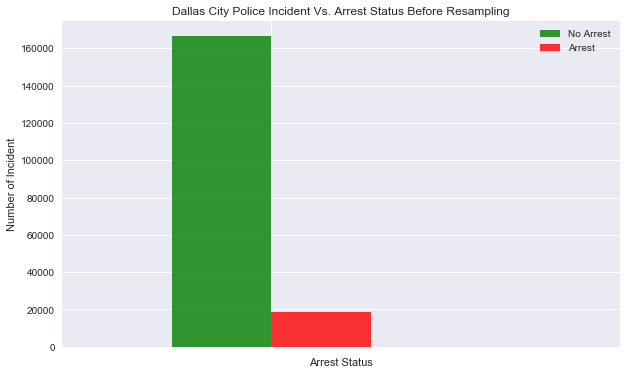

In [12]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Draw bar plot

# data to plot
n_groups = 1
NoArrest=incident.Arrest_status.value_counts()[0]
Arrest=incident.Arrest_status.value_counts()[1]
 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

Class 0: 94192
Class 1: 44893
Class 2: 27847
Class 3: 18039


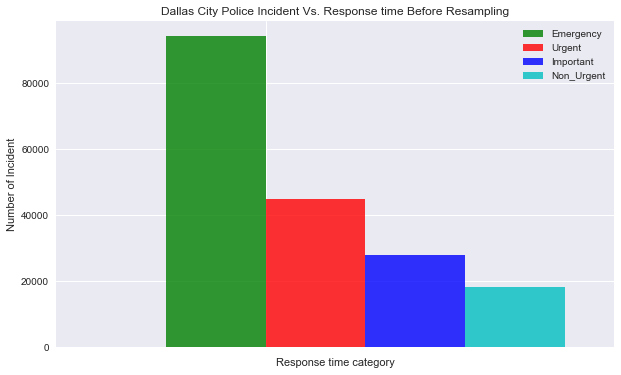

In [13]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Res_time_category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Class 3:', target_count[3])

# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
# print('Proportion1:', round(target_count[0] / target_count[2], 2), ': 1')
# print('Proportion2:', round(target_count[0] / target_count[3], 2), ': 1')

# (0-11)(Emergency), 11-31(Urgent), 31-60(Important), (60-max)(Non_Urgent)


# data to plot
n_groups = 1
Emergent=incident.Res_time_category.value_counts()[0]
Urgent=incident.Res_time_category.value_counts()[1]
Important=incident.Res_time_category.value_counts()[2]
Non_Urgent=incident.Res_time_category.value_counts()[3] 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, Emergent, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Emergency')
 
plt.bar(index + bar_width, Urgent, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Urgent')
 
plt.bar(index + bar_width+ 0.5, Important, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Important')

plt.bar(index + bar_width+ 1.0 , Non_Urgent, bar_width,
                 alpha=opacity,
                 color='c',
                 label='Non_Urgent')

plt.xlabel('Response time category')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Response time Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

### Resampling (Downsampling) the data set

Based on the above analysis, we have almost 10 times the number of samples for perpetrator not being arrested compared to where an arrest is made. 

In an imbalanced class, we cannot reliably use accuracy to measure performance. This makes training the model very tricky. The model may predict the majority class better and sometimes ignore the minority class completely. There are 2 ways to blanace the data set: downsampling and upsampling. We selected the downsampling as we have a big dataset. It will run long time in SVM if we choose upsampling method.

We perform down-sample by 
1. Separating observations based on class
2. Resample the majority class without replacement after setting the number of samples to match the minorit class count
3. Combine the down-sampled majority class and the original minority class

Finally, we plot the distribution of distinct classes of the response variable to check that it is balanced before proceeding with further analysis.

Source: https://elitedatascience.com/imbalanced-classes

In [14]:
# Import resample package
from sklearn.utils import resample

# Downsampling
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=18520,  # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()

1    18520
0    18520
Name: Arrest_status, dtype: int64

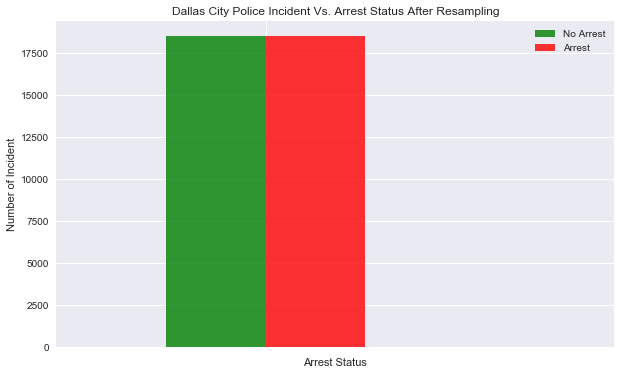

In [15]:
n_groups = 1
NoArrest=df_downsampled.Arrest_status.value_counts()[0]
Arrest=df_downsampled.Arrest_status.value_counts()[1]
 
# create plot
#ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, 
        NoArrest, 
        bar_width,
        alpha=opacity,
        color='g',
        label='No Arrest')
 
plt.bar(index + bar_width, 
        Arrest, 
        bar_width,
        alpha=opacity,
        color='r',
        label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
#plt.tight_layout()
plt.show()

Class 0: 21280
Class 1: 8334
Class 2: 4572
Class 3: 2854


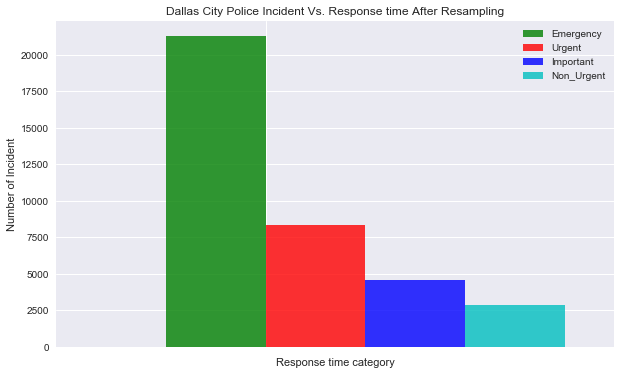

In [16]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = df_downsampled.Res_time_category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Class 3:', target_count[3])

# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
# print('Proportion1:', round(target_count[0] / target_count[2], 2), ': 1')
# print('Proportion2:', round(target_count[0] / target_count[3], 2), ': 1')

# (0-11)(Emergency), 11-31(Urgent), 31-60(Important), (60-max)(Non_Urgent)


# data to plot
n_groups = 1
Emergent=df_downsampled.Res_time_category.value_counts()[0]
Urgent=df_downsampled.Res_time_category.value_counts()[1]
Important=df_downsampled.Res_time_category.value_counts()[2]
Non_Urgent=df_downsampled.Res_time_category.value_counts()[3] 

# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, Emergent, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Emergency')
 
plt.bar(index + bar_width, Urgent, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Urgent')
 
plt.bar(index + bar_width+ 0.5, Important, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Important')

plt.bar(index + bar_width+ 1.0 , Non_Urgent, bar_width,
                 alpha=opacity,
                 color='c',
                 label='Non_Urgent')

plt.xlabel('Response time category')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Response time After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

In [17]:
# copy the down sampled dataset to the original incident data frame and continue the analysis
incident= df_downsampled.copy()

### Collinearity

During Lab 1 data exploration, the team identified the attributes in the original dataset to have multicollinearity. In other words, one predictor variable in the regression model can be linearly predicted from the others with a substantial degree of accuracy.

During this Mini Lab exercise, some additional collinearity was introduced because:
 * Continous Variables were converted to Categorical variables (e.g.: Response Time & Victim Age are converted to Categorical)
 * Derived Features based on (or a combination of) values of existing features (e.g.: Social Crime Score)
 * Identical features where one was a roll up of the other (e.g.: Watch & Call Received Hour)
 
Based on the analysis of Correlation Matrix, we would be dropping one of the columns from the pair that are highly correlated.

In [18]:
# Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)

# REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Res_time_category        Response_time              0.955328
Drug_Related             Social_crime_score         0.841239
Watch                    Call_Received_Hour         0.732130
UCR_Offense_Description  UCR_Offense_Name           0.690865
Social_crime_score       Gang_Related_Offense       0.565914
                                                      ...   
Arrest_status            Response_time             -0.179920
                         UCR_Offense_Description   -0.244570
Victim_Race              Division                  -0.285132
Arrest_status            UCR_Offense_Name          -0.311077
Division                 Y_Coordinate              -0.632288
dtype: float64


In [19]:
# Drop highly correlated, insignificant and high VIF variables.
incident = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime','Response_time'], axis=1)

# Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)

# Remove Duplicates
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

UCR_Offense_Name               UCR_Offense_Description          0.690865
Call_Dispatch_Date_Time_epoch  Call_Received_Date_Time_epoch    0.313625
Victim_Race                    Y_Coordinate                     0.252684
Call_Cleared_Date_Time_epoch   Call_Received_Date_Time_epoch    0.140156
Victim_Race                    UCR_Offense_Name                 0.129969
                                                                  ...   
Res_time_category              Arrest_status                   -0.178764
UCR_Offense_Description        Arrest_status                   -0.244570
Division                       Victim_Race                     -0.285132
UCR_Offense_Name               Arrest_status                   -0.311077
Division                       Y_Coordinate                    -0.632288
dtype: float64


# Data Preparation Part 2

In [ ]:
incident.describe()

#### DATA DESCRIPTION TABLE HERE !!!!!!!!!!!!!!!!!!!

Below are the definitions and descriptions of attributes we selected for our analysis:

#### Attribues from original dataset:

Attribute|Data Type|Description|%missing    
:--------- | :----------------- | :-------------               | :---------
<p align="left">Watch</p>|Norminal|<p align="left">Police watch 1st 2nd or 3rd (1st watch = Late Night, 2nd watch = Days and 3rd watch = Evenings)</p>|0.00
<p align="left">Day1_of_the_Week</p>|Interval|<p align="left">Day of the indent based on the Date of Occurrence (Date1). Internal use</p>|0.00
<p align="left">Victim_Type</p>|Norminal|<p align="left">Victim Type</p>|5.22
<p align="left">Victim_Race</p>|Norminal|<p align="left">Victim Race</p>|34.53
<p align="left">Victim_Ethnicity</p>|Norminal|<p align="left">Victim Ethnicity</p>|35.13
<p align="left">Victim_Gender</p>|Norminal|<p align="left">Victim Gender</p>|34.50
<p align="left">Victim_Age</p>|Ratio|<p align="left">Victim Age</p>|38.01
<p align="left">Hate_Crime</p>|Interval|<p align="left">Yes or no if offense is a hate crime. We keep this attribute as we may find useful information in it</p>|99.88
<p align="left">Gang_Related_Offense</p>|Interval|<p align="left">Yes or no if offense is gang realated</p>|15.67
<p align="left">Drug_Related_Incident</p>|Interval|<p align="left">Yes or no if incident is drug related</p>|0.03
<p align="left">UCR_Offense_Name</p>|Norminal|<p align="left">UCR Offense Name</p>|0.02
<p align="left">UCR_Offense_Description</p>|Norminal|<p align="left">UCR Offense Description</p>|0.00

#### Attribute we calculated:
Attribute|Data Type|Description    
:--------- | :----------------- | :-------------               
<p align="left">Number_of_offense</p>|Interval|<p align="left">Number of Offense, calculated attribute</p>
<p align="left">Response_time</p>|Interval|<p align="left">Response time, call dispatched time minus call received time, calculated attribute which will be used as response variable for task 2.</p>
<p align="left">Arrest_status</p>|Interval|<p align="left">Arrest or No Arrest, calculated attribute which will be used as response variable for task 1.</p>
<p align="left">Call_Received_Hour</p>|Interval|<p align="left">Call Received Hours, calculated attribute</p>
<p align="left">IsMale</p>|Interval|<p align="left">Is Male or Not, calculate from the Victim Gender, calculated attribute</p>
<p align="left">Social_crime_score</p>|Interval|<p align="left">Social crime score, calculated attribute from Gang_Related_Offense, Drug_Related_Incident</p>
<p align="left">Call_Received_Date_Time_epoch</p>|Interval|<p align="left">Call Received Time with numeric format, calculated attribute</p>
<p align="left">Call_Cleared_Date_Time_epoch</p>|Interval|<p align="left">Call Cleared Time with numeric format, calculated attribute</p>
<p align="left">Call_Dispatch_Date_Time_epoch</p>|Interval|<p align="left">Call Dispatch Time with numeric format, calculated attribute</p>

# Modeling and Evaluation 1

- Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). 

The performance of the Classification models will be measured using the following evaluation metrics:

 - Accuracy: **True positive + True negative / (True positive + False positive + True negative + False negative)**. Refers to the closeness of a measured value to a standard or known value. It is the percentage of correct predictions
 
 - Precision: **True positive / (True positive + False positive)**. Refers to the closeness of two or more measurements to each other. It means that an algorithm returned substantially more relevant results than irrelevant ones.
 
 - Recall: **True positive / (True positive + False negative)**. Refres to the measure of completeness or quantity. It means that an algorithm returned most of the relevant results.
 
 - F1 score: Is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 score is usually more useful than accuracy, especially with an uneven class distribution
 
 - ROC & AUC: AUC is an abbrevation for area under the curve. It is used in classification analysis in order to determine which of the models predicts the classes best. An example of its application are ROC curves. Here, the true positive rates are plotted against false positive rates.

- Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
The metrics above provide the best measures to evaluate the models as they deliver a consistent scale on which models can be compared to each other. These types of metrics are scalar in nature where the entire model performance can be presented using a single score value. Thus, making it easier to do the comparison and analysis, although it could mask subtle details of their behaviours. Classification accuracy is the easiest classification metric to understand, but it does not tell you the underlying distribution of response values. It also does not tell you what "types" of errors the classifier is making. 

The choice of metric depends on the business objective of focus. Identification of the false positives or false negatives are important so they can be reduced as appropriate to better meet objectives. Medical applications for example i.e. identification of cancer or other ailments require a much higher degree of accuracy, precision and recall compared to other industry applications. 

Confusion matrices provide a more complete picture of how the classifier is performing and also allows for the computation of various classification metrics which guide model selection.

Which metrics should you focus on?

Choose metric with relevant variable (FP or FN in the equation)
If a positive class is preferable then Optimize for precision or specificity
If a negative class is preferred then Optimize for sensitivity

- NearestCentroid: The metric to use when calculating distance between instances in a feature array. If metric is a string or callable, it must be one of the options allowed by metrics.pairwise.pairwise_distances for its metric parameter. The centroids for the samples corresponding to each class is the point from which the sum of the distances (according to the metric) of all samples that belong to that particular class are minimized. If the “manhattan” metric is provided, this centroid is the median and for all other metrics, the centroid is now set to be the mean.


# Modeling and Evaluation 2 

- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

The **Stratified shufflesplit** cross validation iterator was chosen for dividing the data into training and testing data sets.  It provides train/test indices to split data into the train and test sets.

- This cross-validation method is a merge of the StratifiedKFold and ShuffleSplit iterators, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

- In stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, this means that each fold contains roughly the same proportions of the two types of class labels.

The difference between StratifiedKFold and StratifiedShuffleSplit is that StratifiedKFold just shuffles and splits once, therefore the test sets do not overlap, while StratifiedShuffleSplit shuffles each time before splitting, and it splits n_splits times, therefore the resulting test sets can overlap.

    
Parameters:	
y : array, [n_samples]

Labels of samples.

n_iter : int (default 10)

Number of re-shuffling & splitting iterations.

test_size : float (default 0.1), int, or None

If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is automatically set to the complement of the train size.

train_size : float, int, or None (default is None)

If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.

random_state : int or RandomState

Pseudo-random number generator state used for random sampling.

# Modeling and Evaluation 3 

- Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

### k-NN
In KNN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method (it does not make any assumptions on the underlying data distribution) used for classification. The input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression. It is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g. distance functions).

##### Limitations of k-NN
- In high dimensions, points that may be similar may have very large distances. All points will be far away from each other and our intuition for distances in simple 2 and 3-dimensional spaces breaks down. This might feel unintuitive at first, but this general problem is called the “Curse of Dimensionality“.

- Each input variable can be considered a dimension of a p-dimensional input space. For example, if you had two input variables x1 and x2, the input space would be 2-dimensional.

- As the number of dimensions increases the volume of the input space increases at an exponential rate.

##### Prepping for k-NN
- Rescale Data: KNN performs much better if all of the data has the same scale. Normalizing your data to the range [0, 1] is a good idea. It may also be a good idea to standardize your data if it has a Gaussian distribution.

- Address Missing Data: Missing data will mean that the distance between samples can not be calculated. These samples could be excluded or the missing values could be imputed.

- Lower Dimensionality: KNN is suited for lower dimensional data. You can try it on high dimensional data (hundreds or thousands of input variables) but be aware that it may not perform as well as other techniques. KNN can benefit from feature selection that reduces the dimensionality of the input feature space.

### RANDOM FORESTS
Source: https://www.datascience.com/resources/notebooks/random-forest-intro

Random forests, also known as random decision forests, are a popular ensemble method to build predictive models for both classification and regression. The ensemble methods uses multiple learning models to gain better predictive results — in the case of a random forest, the model creates an entire forest of random uncorrelated decision trees to arrive at the best possible answer.

Decision trees are simple but intuitive models that utilize a top-down approach in which the root node creates binary splits until a certain criteria is met. This binary splitting of nodes provides a predicted value based on the interior nodes leading to the terminal (final) nodes. In a classification context, a decision tree will output a predicted target class for each terminal node produced.

Source: www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#workings
##### Features of Random Forests
- Unexcelled in accuracy among current algorithms.
- Runs efficiently on large data bases.
- Can handle thousands of input variables without variable deletion.
- Provides estimates of what variables are important in the classification.
- Generates an internal unbiased estimate of the generalization error as the forest building progresses.
- Effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
- Includes methods for balancing error in class population unbalanced data sets.
- Generated forests can be saved for future use on other data.
- Prototypes are computed that give information about the relation between the variables and the classification.
- Computes proximities between pairs of cases that can be used in clustering, locating outliers, or (by scaling) give interesting views of the data.
- Capabilities of the above can be extended to unlabeled data, leading to unsupervised clustering, data views and outlier detection.
- Offers an experimental method for detecting variable interactions.

##### Limitations to Decision Trees
Decision trees tend to have high variance when they utilize different training and test sets of the same data, since they tend to overfit on training data. This leads to poor performance on unseen data. Unfortunately, this limits the usage of decision trees in predictive modeling. However, using ensemble methods, we can create models that utilize underlying decision trees as a foundation for producing powerful results.


### SVM
##### Interpreting Support Vectors (from mini lab)

For SVM models, the interpretation of field importance is not as straight forward. Non-linear SVM models create hyperplanes in infinite dimensional space. To accomplish this the source data used in the analysis must be mapped to a higher dimensional space and as a result is very different from the original data. Because of this it is not possible to determine feature weights like we did with the logisitc regessions above.

However, we can examine individual features to investigate how SVM approaches classification problems.In the case below, we are vizualizing decision boundaries of two features i.e UCR_Offense_Name and Division.

- In this section, the models for classification of two task where Arrest Status and Response Time Category will be build.
- Models per task = 3 
- These are two predictive tasks spanning two different modes of machine learning. 
- Both prediction as a classification task.
- The available features will be utilized for classiffication of Arrest status. 

- MAYBE BASE LINE AS LOGIT

The cross validation will be performed for each task as mentioned........***

### TASK 1
- Arrest Status Classification

In [22]:
incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37040 entries, 111777 to 255143
Data columns (total 18 columns):
Division                         37040 non-null int8
Day1_of_the_Week                 37040 non-null int8
Victim_Type                      37040 non-null int8
Victim_Race                      37040 non-null int8
Victim_Age                       37040 non-null int32
UCR_Offense_Name                 37040 non-null int8
X_Coordinate                     37040 non-null float64
Y_Coordinate                     37040 non-null float64
UCR_Offense_Description          37040 non-null int8
Number_of_offense                37040 non-null int32
Arrest_status                    37040 non-null int64
Call_Received_Hour               37040 non-null float64
Res_time_category                37040 non-null int8
IsMale                           37040 non-null int32
Social_crime_score               37040 non-null int64
Call_Received_Date_Time_epoch    37040 non-null int64
Call_Cleared_Date_Time

In [23]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']
# Features with no predictive features with respect to resposne variable
inci_X = incident.drop(['Arrest_status'],axis=1)

from sklearn.preprocessing import StandardScaler
#Scale data
scaler = StandardScaler()
inci_X = scaler.fit_transform(inci_X)
#Save as data frames
inci_X = pd.DataFrame(inci_X)

In [24]:
# # Credit: https://etav.github.io/

# from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
# df2_vif = pd.DataFrame()
# df2_vif["VIF Factor"] = [vif(inci_X.values, i) for i in range(inci_X.shape[1])]
# df2_vif["features"] = inci_X.columns
# print("VIF Factors before Scaling")
# df2_vif

In [25]:
# # Credit: https://etav.github.io/

# from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# df2_vif = pd.DataFrame()
# df2_vif["VIF Factor"] = [vif(df_inci_X_scaled.values, i) for i in range(df_inci_X_scaled.shape[1])]
# df2_vif["features"] = inci_X.columns
# print("VIF Factors after Scaling")
# df2_vif

In [26]:
# # LOGISTIC REGRESSION: SUMMARY TABLE WITHOUT SCALING- FEATURE SIGNIFICANCE, CROSS VALIDATION OF FULL MODEL
# from sklearn import metrics as mt
# import statsmodels.api as sm
# logit_model = sm.Logit(inci_Y, inci_X)
# result = logit_model.fit()
# print(result.summary2())


###### Cross Validation

For the below model execution, we use Cross Validation to improve the model classification. We use the below settings for the cross validation module.

    1. The data is divided into 80/20 train -test split.
    2. 10 folds cross validation
    3. Random seed with random state 0 for random test and training splits for each iteration of cross validation

In [27]:
%%time
from sklearn.model_selection import ShuffleSplit
# Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)


inci_X = inci_X.as_matrix().astype(np.float)
inci_Y = inci_Y.as_matrix().astype(np.float)

for trainidx, testidx in cv.split(inci_X,inci_Y):
    X_train, X_test = inci_X[trainidx], inci_X[testidx]    
    y_train, y_test = inci_Y[trainidx], inci_Y[testidx]

Wall time: 99.2 ms


### TASK 1.1
###### KNN Classification 

- Parameter Optimization

K-Nearest Neighbor (KNN) classification is valid option for this dataset since the dataset has been preprocessed and it has no missing values. Parameter selections are critical to the performance of KNN classifiers; therefore, substantial time and effort was put forth to fully investigate the optimal parameters.

#### Parameter Settings


**Writeup

In [28]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
acc_score = []
pres_score = []

for K in np.arange(1, 20, 1):
    print("Iteration:: ",K)
    knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    knn.fit(X_train,y_train)
    yhat = knn.predict(X_test)
    
    error_rate.append(np.mean(yhat != y_test))
    acc = accuracy_score(y_test, yhat)
    pres = precision_score(y_test, yhat)
    acc_score.append(acc)
    pres_score.append(pres)
    print('Classification Report')
    print(classification_report(y_test, yhat))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, yhat))
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
    print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))
    
    


Iteration::  1
Classification Report
              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60      3658
         1.0       0.61      0.61      0.61      3750

   micro avg       0.60      0.60      0.60      7408
   macro avg       0.60      0.60      0.60      7408
weighted avg       0.60      0.60      0.60      7408

Confusion Matrix
[[2178 1480]
 [1468 2282]]
Accuracy of classifier with 1 neighbors is: 0.60
Precision Score of classifier with 1 neighbors is: 0.61
Iteration::  2
Classification Report
              precision    recall  f1-score   support

         0.0       0.57      0.80      0.66      3658
         1.0       0.68      0.40      0.50      3750

   micro avg       0.60      0.60      0.60      7408
   macro avg       0.62      0.60      0.58      7408
weighted avg       0.62      0.60      0.58      7408

Confusion Matrix
[[2937  721]
 [2246 1504]]
Accuracy of classifier with 2 neighbors is: 0.60
Precision Score of classifier 

Wall time: 50.1 ms


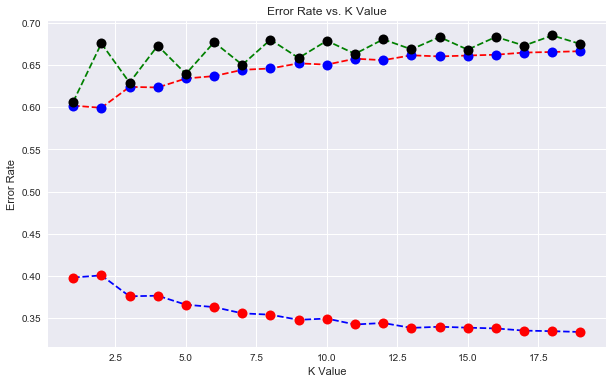

In [29]:
%%time

plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 20, 1),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.plot(np.arange(1, 20, 1),acc_score,color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.plot(np.arange(1, 20, 1),pres_score,color='green', linestyle='dashed', marker='o', markerfacecolor='black', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')

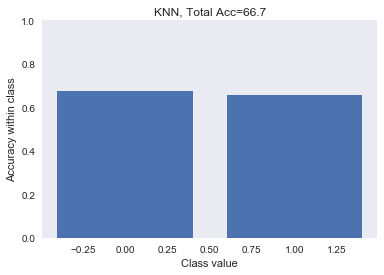

In [30]:
from sklearn import metrics as mt

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
plot_class_acc(y_test,yhat,title="KNN")

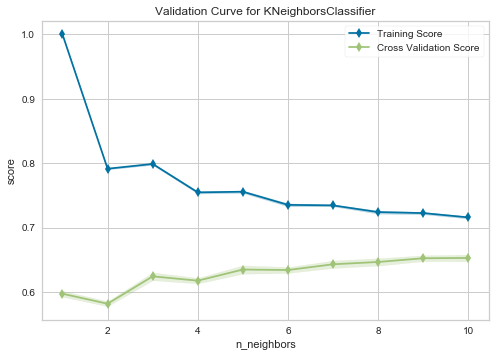

In [31]:
%%time
# Validation Curv
from yellowbrick.model_selection import ValidationCurve
from sklearn.neighbors import KNeighborsClassifier

param_range = np.arange(1, 11)

oz = ValidationCurve(
    KNeighborsClassifier(), param_name="n_neighbors",
    param_range=param_range, cv=cv, scoring="f1_weighted", n_jobs=4,
)


oz.fit(X_train,y_train)
oz.poof()


### TASK 1.2

#### RandomForest Classifier 

Accuracy 0.7298866090712743
Precision 0.7551794572512401
Classification Report
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74      3658
         1.0       0.76      0.69      0.72      3750

   micro avg       0.73      0.73      0.73      7408
   macro avg       0.73      0.73      0.73      7408
weighted avg       0.73      0.73      0.73      7408

Confusion Matrix
[[2819  839]
 [1162 2588]]


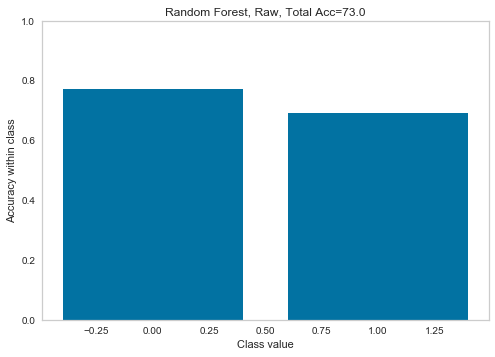

Wall time: 4 s


In [32]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)

clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
    
total_accuracy = mt.accuracy_score(y_test, yhat)
total_precision = precision_score(y_test, yhat)
print ('Accuracy', total_accuracy)
print ('Precision', total_precision)
print('Classification Report')
print(classification_report(y_test, yhat))
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))
plot_class_acc(y_test,yhat,title="Random Forest, Raw")

In [ ]:
# Validation Curv
from yellowbrick.model_selection import ValidationCurve
from sklearn.ensemble import RandomForestClassifier

param_range = np.arange(1, 11)

oz = ValidationCurve(
    RandomForestClassifier(), param_name="max_depth",
    param_range=param_range, cv=cv, scoring="r2", n_jobs=4,
)


oz.fit(X_train,y_train)
oz.poof()

In [33]:
import forestci as fci
n_trees = 2000
mpg_forest = RandomForestRegressor(n_estimators=n_trees, random_state=42)
mpg_forest.fit(X_train, y_train)

plt.ylabel('Predicted MPG')
plt.show()



Failed to import duecredit due to No module named 'duecredit'


NameError: name 'RandomForestRegressor' is not defined

### TASK 1.3

### NearestCentroid

In [ ]:
%%time
from sklearn.neighbors.nearest_centroid import NearestCentroid
for d in ['l1', 'l2', 'cosine', 'euclidean']:
    clf = NearestCentroid(metric=d)
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    pres = precision_score(y_test, yhat)
    print('Classification Report')
    print(classification_report(y_test, yhat))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, yhat))
    print('Accuracy of classifier with %s metric is: %.2f'%(d,acc))
    print('Precision Score of classifier with %s metric is: %.2f'%(d,pres))

### TASK 2
- Response Time Category Status Classification

In [ ]:
# Y Response variable dataframe
inci_res_Y = incident['Res_time_category']
# Features with no predictive features with respect to resposne variable
inci_res_X = incident.drop(['Res_time_category', 'Response_time'],axis=1)  # Added Response_time  to drop as it was causing accuracy to be 1

                                                                            # Try removing ARREST STATUS for this too
from sklearn.preprocessing import StandardScaler
#Scale data
scaler = StandardScaler()
inci_res_X = scaler.fit_transform(inci_res_X)
#Save as data frames
inci_res_X = pd.DataFrame(inci_res_X)

In [ ]:
%%time
inci_res_X = inci_res_X.as_matrix().astype(np.float)
inci_res_Y = inci_res_Y.as_matrix().astype(np.float)

for trainidx, testidx in cv.split(inci_res_X,inci_res_Y):
    X_train_R, X_test_R = inci_res_X[trainidx], inci_res_X[testidx]    
    y_train_R, y_test_R = inci_res_Y[trainidx], inci_res_Y[testidx]

### TASK 2.1
- KNN

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
acc_score = []
pres_score = []

for K in np.arange(1, 20, 1):
    print("Iteration:: ",K)
    knn = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    knn.fit(X_train_R,y_train_R)
    yhat= knn.predict(X_test_R)
    
    error_rate.append(np.mean(yhat != y_test))
    acc = accuracy_score(y_test_R, yhat)
    pres = precision_score(y_test_R, yhat, average='weighted')
    acc_score.append(acc)
    pres_score.append(pres)
    print('Classification Report')
    print(classification_report(y_test_R, yhat))
    print('Confusion Matrix')
    print(confusion_matrix(y_test_R, yhat))
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,acc))
    print('Precision Score of classifier with %d neighbors is: %.2f'%(K,pres))

### TASK 2.2
- Random forest classifier

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1, oob_score=True, class_weight="balanced")

clf.fit(X_train_R,y_train_R)
yhat = clf.predict(X_test_R)
    
total_accuracy = mt.accuracy_score(y_test_R, yhat)
total_precision = precision_score(y_test_R, yhat, average='weighted')
print ('Accuracy', total_accuracy)
print ('Precision', total_precision)
print('Classification Report')
print(classification_report(y_test_R, yhat))
print('Confusion Matrix')
print(confusion_matrix(y_test_R, yhat))
plot_class_acc(y_test_R,yhat,title="Random Forest, Raw")

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB


clf_pipe = Pipeline(
    [('PCA',PCA(n_components=11, svd_solver='randomized')),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))]
)

total_accuracy = mt.accuracy_score(y_test_R, yhat)
total_precision = precision_score(y_test_R, yhat, average='weighted')
print ('Pipeline Accuracy', total_accuracy)
print ('Precision', total_precision)
print('Classification Report')
print(classification_report(y_test_R, yhat))
print('Confusion Matrix')
print(confusion_matrix(y_test_R, yhat))
plot_class_acc(y_test_R,yhat,title="Random Forest, Raw")  # PCA

### Task 2.3
- NearestCentroid

In [ ]:
%%time
from sklearn.neighbors.nearest_centroid import NearestCentroid
for d in ['l1', 'l2', 'cosine', 'euclidean']:
    clf = NearestCentroid(metric=d)
    clf.fit(X_train_R, y_train_R)
    yhat = clf.predict(X_test_R)
    acc = accuracy_score(y_test_R, yhat)
    pres = precision_score(y_test_R, yhat, average='weighted')
    print('Classification Report')
    print(classification_report(y_test_R, yhat))
    print('Confusion Matrix')
    print(confusion_matrix(y_test_R, yhat))
    print('Accuracy of classifier with %s metric is: %.2f'%(d,acc))
    print('Precision Score of classifier with %s metric is: %.2f'%(d,pres))

# Modeling and Evaluation 4

- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.



In [ ]:
## Credit To: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# models = []
# models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))

# ***********MODELS FUNCTION*************
# evaluate each model in turn
def Results_analysis(fmodels, fscoring, fX, fy):
    results = []
    names = []
    #scoring = 'accuracy'
    for name, model in fmodels:
        if (fscoring == 'accuracy'):
            skf = StratifiedKFold(n_splits=10, random_state=seed)
        else:
            skf = 10
        cv_results = model_selection.cross_val_score(model, fX, fy, cv=skf, scoring=fscoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    sns.boxplot(x=names, y=results, palette="Set1")
    plt.show()
    
    return [names, results]

### Arrest Status (models in TASK 1)

In [ ]:


## Credit To: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import model_selection

seed = 7
# prepare models
class_models = []
class_models.append(('LDA', LinearDiscriminantAnalysis(n_components=1, priors=None, solver='lsqr')))
class_models.append(('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski', 
                                           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                                           weights='uniform')))
class_models.append(('RF', RandomForestClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1)))
class_models.append(('RFET', ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1)))

class_models.append(('NearestCentroid', NearestCentroid(metric='cosine')))
class_models.append(('NB', GaussianNB()))



classModelResults = Results_analysis(class_models, 'accuracy', X_test, y_test)

### Response Time Category (models in TASK 2)

In [ ]:
## Credit To: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import model_selection

seed = 7
# prepare models
class_models_R = []
# class_models_R.append(('LDA', LinearDiscriminantAnalysis(n_components=1, priors=None, solver='lsqr')))
class_models_R.append(('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski', 
                                           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                                           weights='uniform')))
class_models_R.append(('RF', RandomForestClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1)))
class_models_R.append(('RFET', ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1)))

class_models_R.append(('NearestCentroid', NearestCentroid(metric='l1')))

class_models_R.append(('RF+PCA',Pipeline([('PCA',PCA(n_components=11, svd_solver='randomized')),
                                    ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))])))


classModelResults_R = Results_analysis(class_models_R, 'accuracy', X_test_R, y_test_R)

# Modeling and Evaluation 5 

- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.



In [ ]:
# credit: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# credit: https://stackoverflow.com/questions/5389507/iterating-over-every-two-elements-in-a-list
from math import sqrt
from scipy import stats
# Iterate Pairwise through models and calculate CI
def modelCiComp(modelResults):
    for i in range(len(classModelResults[0])):
        for j in range(i+1, len(classModelResults[1])):
            m1Acc = classModelResults[1][i]
            m2Acc = classModelResults[1][j]
            d = m1Acc - m2Acc
            dBar = np.mean(d)
            v = np.var(d)
            ci = (1/sqrt(len(m1Acc)))*stats.t.ppf(q = .975, df = len(m1Acc) - 1)*sqrt(v)
            ci = "[" + str(round(dBar - ci, 5)) + ", " + str(round(dBar + ci, 5)) + "]"
            print("95% CI for", classModelResults[0][i], "vs", classModelResults[0][j], "=", ci)

#### Arrest Status models

In [ ]:
modelCiComp(classModelResults)

#### Response time category models

In [ ]:
modelCiComp(classModelResults_R)

# Modeling and Evaluation 6 

- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.


#### Arrest status

In [ ]:
# KNN: 0.705720 (0.012338)

# now lets get access to the different properties of our RF
clf = RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1, oob_score=True, class_weight="balanced")

clf.fit(X_train,y_train)
    
print (clf)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)


# oob_SCORE - Very close to accuracy, represents data which are not just a guess and are not placed on the main data for ..
# ..do not use it as a replacement to cross validation

### Response time cat

In [ ]:
# KNN: 0.705720 (0.012338)

# now lets get access to the different properties of our RF
clf = RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1, oob_score=True, class_weight="balanced")

clf.fit(X_train_R, y_train_R)
    
print (clf)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)


# oob_SCORE - Very close to accuracy, represents data which are not just a guess and are not placed on the main data for ..
# ..do not use it as a replacement to cross validation

In [ ]:
# model = RandomForestClassifier()

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train_R, y_train_R)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train_R.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train_R.shape[1]), indices)
plt.ylim([-1, X_train_R.shape[1]])
plt.show()

In [ ]:
# from matplotlib import pyplot as plt

# def plotCoef(coef, names, t):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names), key=lambda x: abs(x[0])))
#     plt.figure(figsize=(9,12))
#     barlist = plt.barh(range(len(names)), imp, align='center')
#     for x in np.nditer(np.where(np.asarray(list(imp)) < 0)):
#         barlist[x].set_color('r')
#     plt.yticks(range(len(names)), names)
#     plt.title(t)
#     plt.show()


In [ ]:
# plotCoef(regGridSearch.best_estimator_.coef_[0], inci_X.columns.values, "Manual Logistic Features")
# list(sorted(zip(regGridSearch.best_estimator_.coef_.ravel(), inci_X.columns.values)))

# Deployment

- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 



# Exceptional Work 

- You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

# TEST

In [ ]:
# %%time
# from sklearn.decomposition import PCA 
# from sklearn.pipeline import Pipeline

# # setup pipeline to take PCA, then fit a KNN classifier
# clf_pipe = Pipeline(
#     [('PCA_Eric',PCA(n_components=11,svd_solver='randomized')),
#      ('CLF_Eric',KNeighborsClassifier(n_neighbors=1))]
# )

# # now iterate through and get predictions, saved to the correct row in yhat
# for train, test in cv.split(X,y):
#     clf_pipe.fit(X[train],y[train])
#     yhat[test] = clf_pipe.predict(X[test])

# total_accuracy = mt.accuracy_score(y, yhat)
# print ('KNN, pipeline accuracy', total_accuracy)

In [ ]:
# def per_class_accuracy(ytrue,yhat):
#     conf = mt.confusion_matrix(ytrue,yhat)
#     norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
#     return np.diag(norm_conf)

# def plot_class_acc(ytrue,yhat, title=''):
#     acc_list = per_class_accuracy(ytrue,yhat)
#     plt.bar(range(len(acc_list)), acc_list)
#     plt.xlabel('Class value (one per face)')
#     plt.ylabel('Accuracy within class')
#     plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
#     plt.grid()
#     plt.ylim([0,1])
#     plt.show()
    
# plot_class_acc(y,yhat,title="KNN")

In [ ]:
# %%time
# from sklearn.ensemble import RandomForestClassifier

# clf_pipe = Pipeline(
#     [('PCA',PCA(n_components=11, svd_solver='randomized')),
#      ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))]
# )

# # now iterate through and get predictions, saved to the correct row in yhat
# for train, test in cv.split(X,y):
#     clf_pipe.fit(X[train],y[train])
#     yhat[test] = clf_pipe.predict(X[test])
    
# total_accuracy = mt.accuracy_score(y, yhat)
# print ('Pipeline accuracy', total_accuracy)
# plot_class_acc(y,yhat,title="Random Forest + PCA")

In [ ]:
# %%time
# from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)

# # now iterate through and get predictions, saved to the correct row in yhat
# for train, test in cv.split(X,y):
#     clf.fit(X[train],y[train])
#     yhat[test] = clf.predict(X[test])
    
# total_accuracy = mt.accuracy_score(y, yhat)
# print ('Accuracy', total_accuracy)
# plot_class_acc(y,yhat,title="Random Forest, Raw")

- Overall importance of each feature, magnitude of feature importance.

# TREE ENSEMBLE METHOD

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
    ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators)), #takes a long time
    ]

for clf in clf_array:
    acc = cross_val_score(clf[1],X,y)
    print (clf[0], acc.mean())

In [ ]:
# # from sklearn.svm import SVC
# # from sklearn.linear_model import LogisticRegression
# # from sklearn.linear_model import SGDClassifier
# from sklearn.naive_bayes import GaussianNB


# # setup pipeline to take PCA, then fit a different classifier
# clf_pipe = Pipeline(
#     [('PCA',PCA(n_components=11,svd_solver='randomized')),
#      ('CLF',GaussianNB())]
# )

# # now iterate through and get predictions, saved to the correct row in yhat
# for train, test in cv.split(X,y):
#     clf_pipe.fit(X[train],y[train])
#     yhat[test] = clf_pipe.predict(X[test])

# total_accuracy = mt.accuracy_score(y, yhat)
# print ('Pipeline accuracy', total_accuracy)
# plot_class_acc(y,yhat,title="Naive Bayes + PCA")

In [ ]:
# from sklearn.naive_bayes import GaussianNB


# # setup pipeline to take PCA, then fit a different classifier
# clf_pipe = Pipeline(
#     [('PCA',PCA(n_components=11,svd_solver='randomized')),
#      ('CLF',GaussianNB())]
# )

# yhat_score = np.zeros((y.shape[0],len(X)))

# # now iterate through and get predictions, saved to the correct row in yhat
# for train, test in cv.split(X,y):
#     clf_pipe.fit(X[train],y[train])
#     yhat[test] = clf_pipe.predict(X[test])
#     yhat_score[test] = clf_pipe.predict_proba(X[test])

# total_accuracy = mt.accuracy_score(y, yhat)
# print ('Pipeline accuracy', total_accuracy)

In [ ]:
# import seaborn as sns
# sns.set_palette("dark")
# # code manipulated from http://scikit-learn.org/stable/auto_examples/plot_roc.html
# from sklearn.preprocessing import label_binarize

# # Compute ROC curve for a subset of interesting classes
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in np.unique(y):
#     fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
#     roc_auc[i] = mt.auc(fpr[i], tpr[i])

# for i in np.random.permutation(60)[0:6]:
#     plt.plot(fpr[i], tpr[i], label='class {0} with {1} instances (area = {2:0.2f})'
#                                    ''.format(i, sum(y==i), roc_auc[i]))

# plt.legend(loc="lower right")  
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.show()

In [ ]:
# # combined ROC over all classes
# one_hot_class_encoding = label_binarize(y,np.unique(y))
# fpr["micro"], tpr["micro"], _ = mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score.ravel())
# roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

# plt.figure(figsize=(12,4))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]))